In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import nltk
from nltk import sent_tokenize, word_tokenize, PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Data Inspection

In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
features_with_nan=[features for features in df_train.columns if df_train[features].isnull().sum()>0]
features_with_nan

['keyword', 'location']

In [7]:
for feature in features_with_nan:
    print(feature,np.round(df_train[feature].isnull().mean()*100,4),"% missing value")

keyword 0.8013 % missing value
location 33.272 % missing value


## should we consider dropping location feature? normally machine learning project drop the column if it has more than 25 % null value

In [8]:
def drop_missing(df):
    i=0
    for col in df:
        if (df[col].isnull().sum()/7613) >0.3:
            df.drop(col,axis=1,inplace=True)
            print('Column',col,'is dropped')
            i+=1
    if i == 0:
        print('No Column Dropped')

#### Check for duplicated value

In [9]:
df_train.duplicated().sum()

0

## Target Analysis

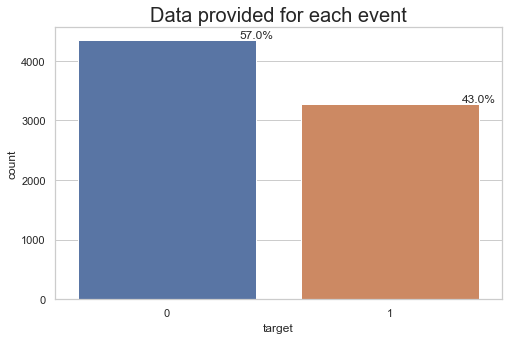

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(df_train))
ax = sns.countplot(x="target", data=df_train)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x,y+30),ha='center')
plt.show()

In [11]:
#We might need a Target analysis per keyword?
#change abbreviation to regular words? https://www.kaggle.com/code/rftexas/text-only-bert-keras?scriptVersionId=31186559

## Preprocessing

### 1. Text Cleaning
#### 1) convert to lowercase and remove stopwords



In [12]:
text = df_train['text']
text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [13]:
def data_cleaning(text):
    text = text.lower()
    # Format regular expressions for data cleaning
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    
    # remove stopwords
    text = text.split()
    stop = set(stopwords.words("english"))
    text = [w for w in text if not w in stop]
    text = " ".join(text)


    return text

In [14]:
df_train['text'] = df_train['text'].apply(data_cleaning)

In [15]:
df_train['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked 'shelter place' notified offic...
3       13 000 people receive wildfires evacuation ord...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria ahrary thetawniest control wild fires cal...
7610    m1 94 01 04 utc 5km volcano hawaii http co zdt...
7611    police investigating e bike collided car littl...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

### 2. Stemming 

In [16]:
def stem(word):  
    regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
    word, suffix = re.findall(regexp, word)[0]
    return word

In [17]:
df_train['text'] = df_train['text'].apply(stem)

In [18]:
df_train['text'] 

0             deeds reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       residents asked 'shelter place' notified offic...
3       13 000 people receive wildfires evacuation ord...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria ahrary thetawniest control wild fires cal...
7610    m1 94 01 04 utc 5km volcano hawaii http co zdt...
7611    police investigating e bike collided car littl...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

### 3.Lemmatization

### 4. Tokenization 

In [19]:
def text_tokenization(text):
    lst_text = text.split()
    
    return lst_text

In [20]:
df_train['text'] = df_train['text'].apply(text_tokenization)

In [21]:
df_train['text'] 

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, 'shelter, place', notified,...
3       [13, 000, people, receive, wildfires, evacuati...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [aria, ahrary, thetawniest, control, wild, fir...
7610    [m1, 94, 01, 04, utc, 5km, volcano, hawaii, ht...
7611    [police, investigating, e, bike, collided, car...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

 ### 5. Sentence Segmentation

### Apply all of things that we did on test dataset as well

In [22]:
df_test['text'] = df_test['text'].apply(data_cleaning)
df_test['text'] = df_test['text'].apply(stem)
#df_test['text'] = df_test['text'].apply(text_tokenization)

## TF-IDF Vectorization

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=lambda x: x,
                        preprocessor=lambda x: x)
train_data_features = tfidf.fit_transform(df_train['text'])

print(train_data_features.shape)

(7613, 22671)


In [35]:
# We split train dataset
y_train = df_train['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data_features, y_train, test_size=0.2, random_state=42)

# Naives Bayes 

In [36]:
nb_classifier = MultinomialNB()

In [37]:
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [38]:
y_pred = nb_classifier.predict(X_test)

In [39]:
classification_report_test =metrics.classification_report(y_test, nb_classifier.predict(X_test))

In [40]:
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       874
           1       0.83      0.64      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



## Random Forest & Logistic Modelling 

In [25]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest classifier
forest = RandomForestClassifier(random_state=42)
# Train model
forest = forest.fit(X_train, y_train)
#score
print(forest.score(X_test, y_test))

0.7741300065659882


#### little Hyperparameter tuning

In [26]:
#Do not run this code it will take 40 mins

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

model_params = {
    'n_estimators': [130,230,500],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4],
}

forest = RandomForestClassifier()
rs = RandomizedSearchCV(forest, model_params, n_iter=100, cv=5, random_state=42)
# Train model
rs.fit(X_train, y_train)
#score
print('Best Score:', rs.best_score_)
print('Best Parameter', rs.best_params_)

C:\Users\nadho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

# Initialize a logistic regression model 
logistic = LogisticRegression(random_state=42)
# Train the model
logistic = logistic.fit(X_train, y_train)
# Print score of model(using test dataset)
print(logistic.score(X_test, y_test))

0.7892317793827971


In [31]:
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression(random_state=42)

parameters = [    
    {'penalty' : ['l2','none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

model = GridSearchCV(logistic, param_grid = parameters, cv = 3, verbose=True, n_jobs=-1)

best_clf = model.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


KeyboardInterrupt: 

In [ ]:
print('Best Score:', best_clf.best_score_)
print('Best Parameter', best_clf.best_params_)

### Result

- TF-IDF
 - Random Forest
    - Basic: 0.7741300065659882
    - Tuning: 0.7888341543513957
 - Logistic Modelling
    - Baisc: 0.7892317793827971
    - Tuning: 0.7939244663382595

## Bag of Words

In [41]:
df_train['target']

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
 
vectorizer = CountVectorizer(tokenizer=lambda x: x,
                        preprocessor=lambda x: x)
bag = vectorizer.fit_transform(df_train['text'])
print(bag.shape)

(7613, 22671)


In [43]:
y_train.shape[0]

6090

In [44]:
bag.shape[0]

7613

In [45]:
# We split train dataset
y_train = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(bag, y_train, test_size=0.2, random_state=42)

# Naives Bayes 

In [46]:
nb_classifier = MultinomialNB()

In [47]:
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [48]:
acc_score = accuracy_score(y_test, y_pred)

In [50]:
classification_report_test =metrics.classification_report(y_test, nb_classifier.predict(X_test))

In [51]:
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       874
           1       0.76      0.74      0.75       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



#### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest classifier
forest = RandomForestClassifier(random_state=42)
# Train model
forest = forest.fit(X_train, y_train)
#score
print(forest.score(X_test, y_test))

0.7800393959290873


In [ ]:
#Do not run this code it will take 40 mins

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

model_params = {
    'n_estimators': [130,230,500],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4],
}

forest = RandomForestClassifier()
rs = RandomizedSearchCV(forest, model_params, n_iter=100, cv=5, random_state=42)
# Train model
rs.fit(X_train, y_train)
#score
print('Best Score:', rs.best_score_)
print('Best Parameter', rs.best_params_)

### Logistic Regression w bag of words

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize a logistic regression model 
logistic = LogisticRegression(random_state=42)
# Train the model
logistic = logistic.fit(X_train, y_train)
# Print score of model(using test dataset)
print(logistic.score(X_test, y_test))

In [ ]:
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression(random_state=42)

parameters = [    
    {'penalty' : ['l2','none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

model = GridSearchCV(logistic, param_grid = parameters, cv = 3, verbose=True, n_jobs=-1)

best_clf = model.fit(X_train, y_train)

best_clf.best_estimator_

In [ ]:
print('Best Score:', best_clf.best_score_)
print('Best Parameter', best_clf.best_params_)

### Result

- TF-IDF
 - Random Forest
    - Basic: 0.7741300065659882
    - Tuning: 0.7888341543513957
 - Logistic Modelling
    - Baisc: 0.7892317793827971
    - Tuning: 0.7955665024630543
- bag of words
 - Random Forest
    - Basic: 0.7800393959290873
    - Tuning: 0.7947454844006568
 - Logistic Modelling
    - Baisc: 0.793827971109652
    - Tuning: 0.7988505747126436

## KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
#training the model
K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

In [42]:
#Evaluating the model
for keys, values in scores.items():
    print(keys, ':', values)

2 : [0.8502463054187193, 0.7603414313854235]
3 : [0.861904761904762, 0.7793827971109653]
4 : [0.828735632183908, 0.767564018384767]
5 : [0.8374384236453202, 0.7662508207485227]
6 : [0.8206896551724138, 0.7734734077478661]
7 : [0.829064039408867, 0.7715036112934996]
8 : [0.815927750410509, 0.7734734077478661]
9 : [0.822495894909688, 0.7701904136572554]
10 : [0.8137931034482758, 0.7734734077478661]
11 : [0.8139573070607553, 0.7747866053841103]
12 : [0.8136288998357963, 0.7760998030203545]
13 : [0.812807881773399, 0.7721602101116218]
14 : [0.8082101806239738, 0.7721602101116218]
15 : [0.809688013136289, 0.768220617202889]
16 : [0.8078817733990148, 0.7708470124753776]
17 : [0.810016420361248, 0.767564018384767]
18 : [0.8077175697865353, 0.7642810242941562]
19 : [0.8091954022988506, 0.7583716349310571]
20 : [0.8068965517241379, 0.7623112278397899]


C:\Users\nadho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


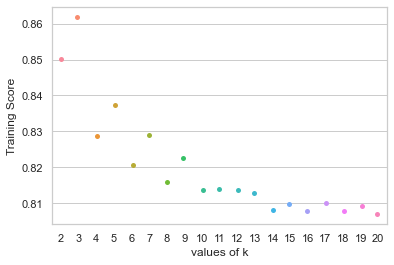

In [43]:
#Plotting the training and test scores graph
ax = sns.stripplot(K, training);
ax.set(xlabel ='values of k', ylabel ='Training Score')
plt.show()

C:\Users\nadho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


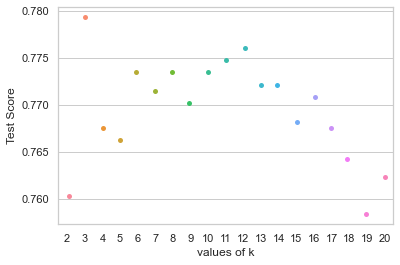

In [44]:
ax = sns.stripplot(K, test);
ax.set(xlabel ='values of k', ylabel ='Test Score')
plt.show()

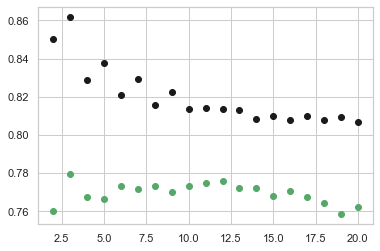

In [45]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()